In [1]:
!pip install python-igraph
import pandas as pd
import igraph as ig

# 1) Load the CSVs, explicitly telling pandas that "\N" means “missing”
airports = pd.read_csv(
    "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
    names=[
        "ID","Name","City","Country","IATA","ICAO",
        "Latitude","Longitude","Altitude","Timezone",
        "DST","Tz","Type","Source"
    ],
    na_values="\\N"
)

routes = pd.read_csv(
    "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
    names=[
        "Airline","AirlineID","Source","SourceID",
        "Dest","DestID","Codeshare","Stops","Equipment"
    ],
    na_values="\\N"
)

# 2) Convert the Airport ID column to strings everywhere
#    (Some rows may already be floats/ints, but treating everything as str is safest.)
airports["ID"] = airports["ID"].astype(int).astype(str)

# 3) Create an empty directed graph
G = ig.Graph(directed=True)

# 4) Add one vertex per airport, using the string‐ID as the “name” attribute
for _, row in airports.iterrows():
    G.add_vertex(
        name=row["ID"],            # e.g. "1590" for TLV
        city=row["City"],
        country=row["Country"],
        iata=row["IATA"],
        lat=row["Latitude"],
        lon=row["Longitude"]
    )

# 5) Build a quick lookup from airport‐ID string → vertex index
#    (igraph uses 0-based integer indices internally, but we’ll refer to them by name)
id2idx = {v["name"]: v.index for v in G.vs}
# 6) Filter and make an explicit copy
valid_routes = routes.dropna(subset=["SourceID", "DestID", "Source", "Dest"]).copy()

# 7) Now it’s safe to overwrite columns without warnings
valid_routes["SourceID"] = valid_routes["SourceID"].astype(int).astype(str)
valid_routes["DestID"]   = valid_routes["DestID"].astype(int).astype(str)


# 8) For each route with Stops = 0 (direct flight), add a directed edge
for _, row in valid_routes[valid_routes["Stops"] == 0].iterrows():
    src_id = row["SourceID"]
    dst_id = row["DestID"]
    # Only add the edge if both endpoints exist in our airport set
    if (src_id in id2idx) and (dst_id in id2idx):
        G.add_edge(id2idx[src_id], id2idx[dst_id])

print(f"Graph has {G.vcount()} vertices and {G.ecount()} edges.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.9 MB/s eta 0:00:00
Graph has 7698 vertices and 66760 edges.


network graph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 55.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


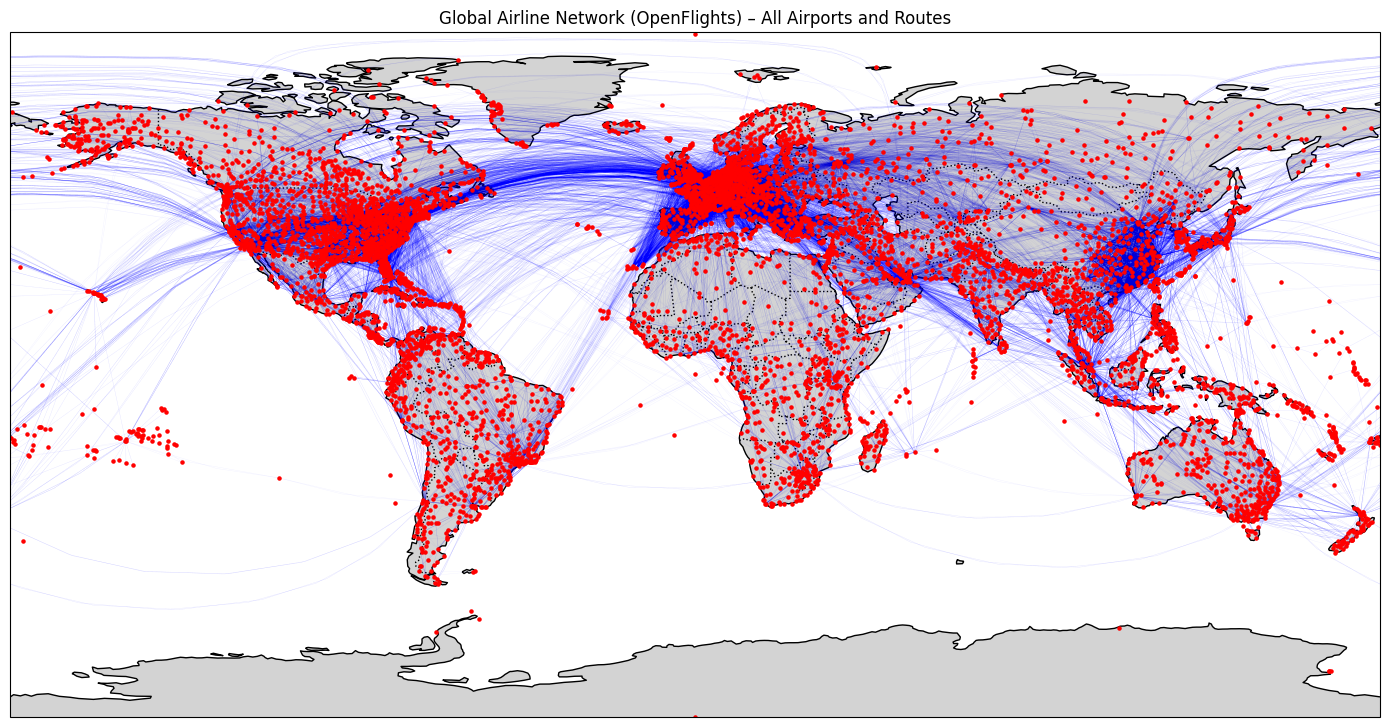

In [2]:
# Visualization of the full airline network on a world map

import matplotlib.pyplot as plt
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assume G is your igraph Graph with all airports and routes already loaded.
# Each vertex has attributes: "lat" and "lon" (floats).

# 1. Extract latitude/longitude for each airport vertex
lats = G.vs["lat"]
lons = G.vs["lon"]

# 2. Prepare a Cartopy figure with PlateCarree projection
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale("110m"), facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE.with_scale("110m"))
ax.add_feature(cfeature.BORDERS.with_scale("110m"), linestyle=":")

# 3. Draw each flight route as a very light line between its endpoints
#    Use low alpha so the density of routes shows major corridors without overpowering the map.
for edge in G.es:
    tail_idx = edge.tuple[0]
    head_idx = edge.tuple[1]
    lat1, lon1 = G.vs[tail_idx]["lat"], G.vs[tail_idx]["lon"]
    lat2, lon2 = G.vs[head_idx]["lat"], G.vs[head_idx]["lon"]
    # Skip any edge with missing coordinates
    if (lat1 is None or lon1 is None or lat2 is None or lon2 is None):
        continue
    # Draw a line segment
    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        transform=ccrs.Geodetic(),
        linewidth=0.3,
        color="blue",
        alpha=0.05
    )

# 4. Overlay all airport nodes as small red dots
ax.scatter(
    lons, lats,
    s=5,
    color="red",
    transform=ccrs.PlateCarree(),
    zorder=2
)

# 5. Add a title
ax.set_title("Global Airline Network (OpenFlights) – All Airports and Routes")

plt.tight_layout()
plt.show()

5 biggest hubs

In [3]:
# Compute and display the top 5 hubs by degree

# 1. Compute total degree (in + out) for each vertex
degrees = G.degree(mode="all")

# 2. Annotate each vertex with its degree
G.vs["degree"] = degrees

# 3. Sort vertices by descending degree and take the top 5
top5 = sorted(G.vs, key=lambda v: v["degree"], reverse=True)[:5]

print("Top 5 hubs by degree:")
for rank, v in enumerate(top5, start=1):
    print(f"{rank}. IATA={v['iata']}, City={v['city']}, Country={v['country']} → degree = {v['degree']}")

Top 5 hubs by degree:
1. IATA=ATL, City=Atlanta, Country=United States → degree = 1826
2. IATA=ORD, City=Chicago, Country=United States → degree = 1108
3. IATA=PEK, City=Beijing, Country=China → degree = 1061
4. IATA=LHR, City=London, Country=United Kingdom → degree = 1047
5. IATA=CDG, City=Paris, Country=France → degree = 1041


shortest path between tel aviv and honolulu

In [4]:
# Find the shortest-path (fewest hops) from Tel Aviv (TLV) to Honolulu (HNL)

# 1. Locate the vertex indices for TLV and HNL based on IATA codes
tlv_vertex = G.vs.find(iata="TLV")
hnl_vertex = G.vs.find(iata="HNL")
tlv_idx = tlv_vertex.index
hnl_idx = hnl_vertex.index

# 2. Compute the shortest path by number of edges (unweighted)
path_result = G.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
# get_shortest_paths returns a list of lists; we want the first (and only) path
path_vertices = path_result[0]

# 3. If no path is found, path_vertices will be empty
if not path_vertices:
    print("No route (by fewest hops) exists from TLV to HNL in the current network.")
else:
    print("Shortest route from TLV to HNL (fewest connections):")
    # 4. Print each hop: IATA code, City, Country
    for hop_idx, v_idx in enumerate(path_vertices, start=1):
        v = G.vs[v_idx]
        print(
            f"{hop_idx}. {v['iata']}  "
            f"({v['city']}, {v['country']})"
        )
    print(f"Total flights (hops): {len(path_vertices) - 1}")

Shortest route from TLV to HNL (fewest connections):
1. TLV  (Tel-aviv, Israel)
2. PEK  (Beijing, China)
3. HNL  (Honolulu, United States)
Total flights (hops): 2


network disruption

<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


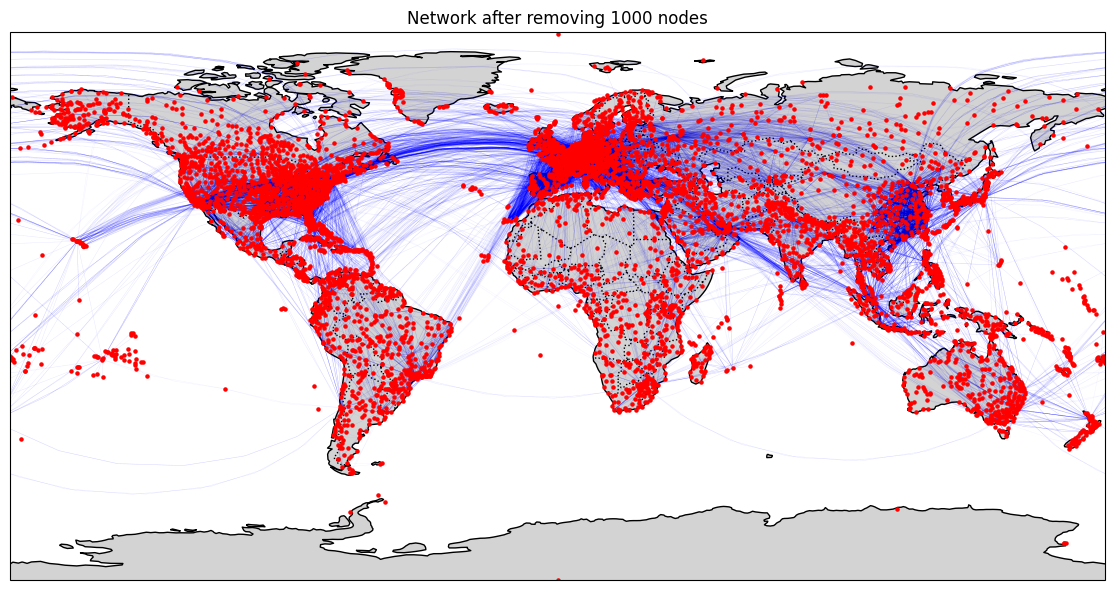

<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


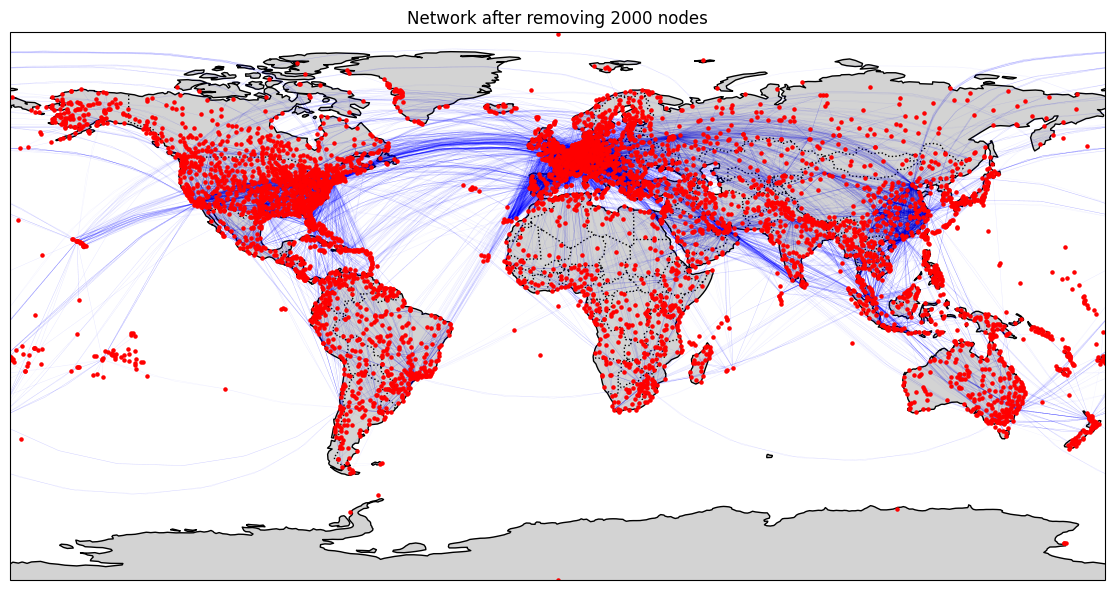

<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


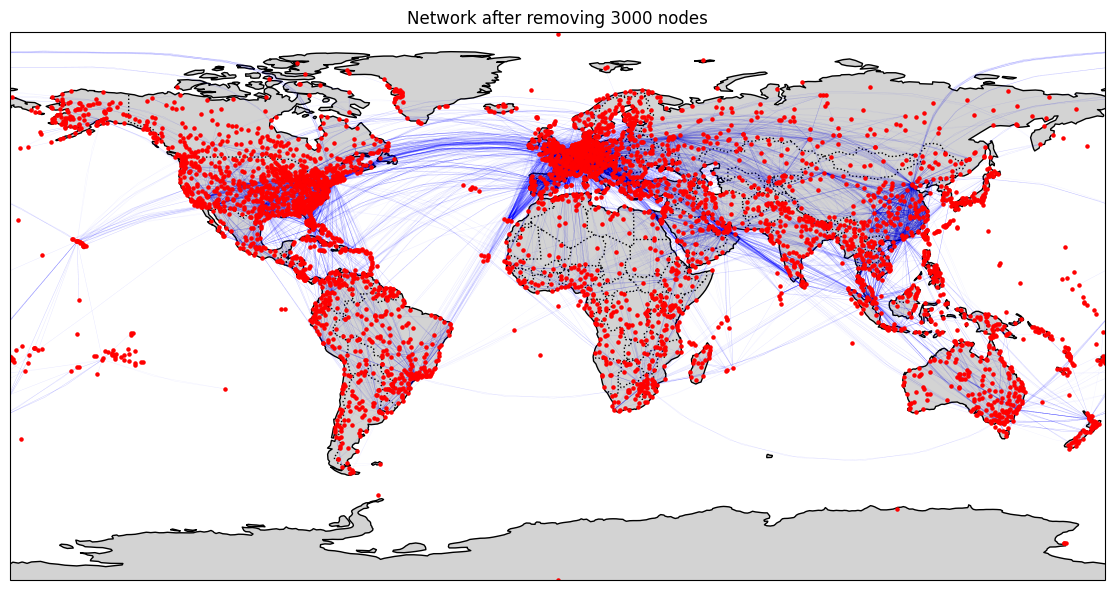

<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


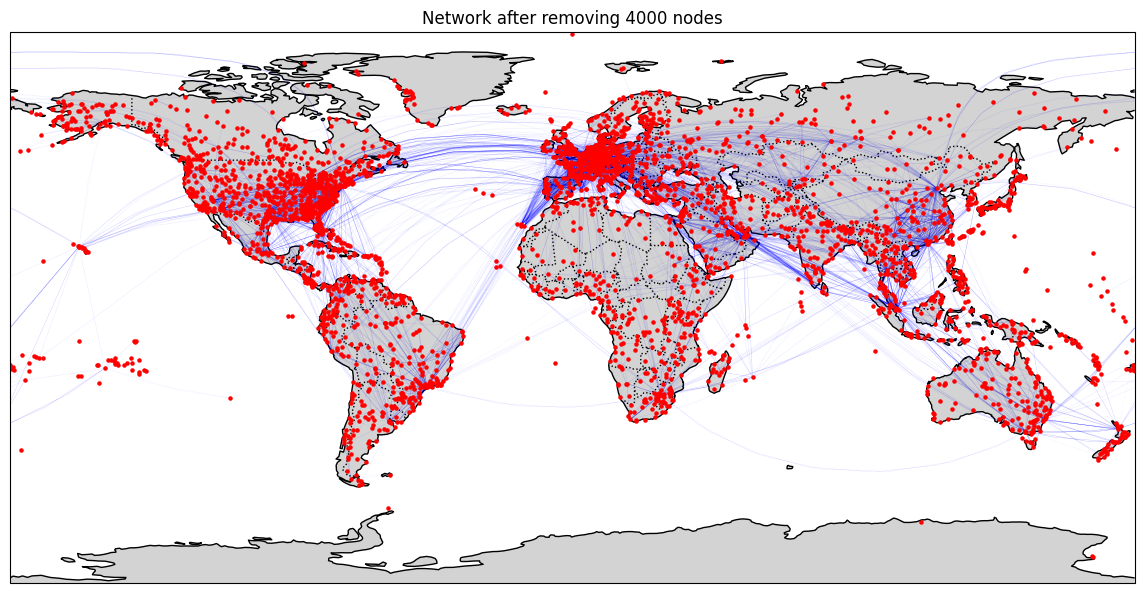

<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


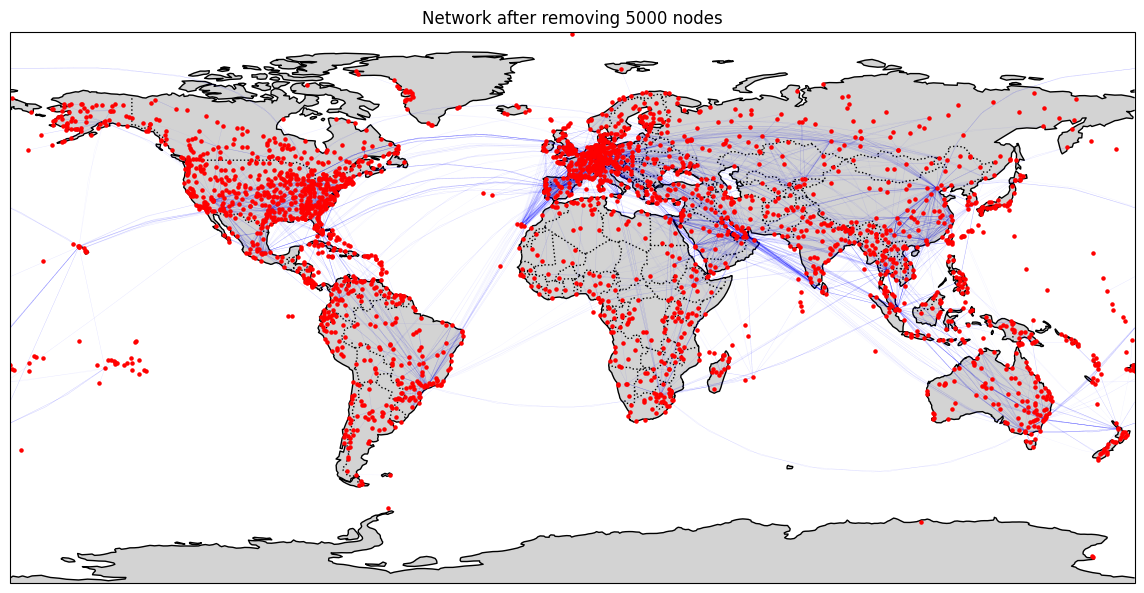

<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


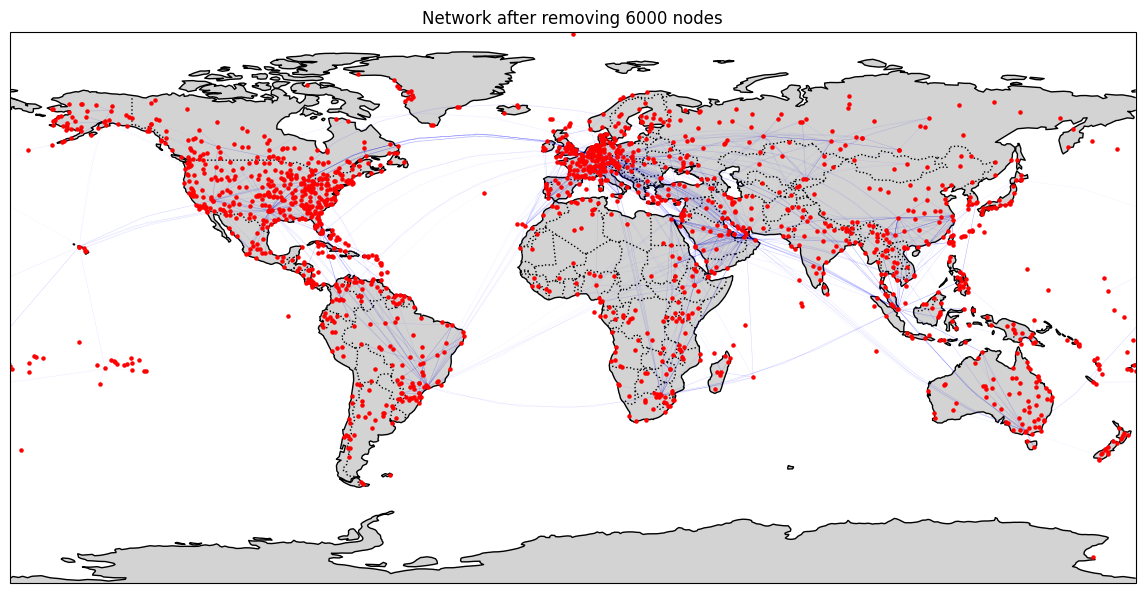

<ipython-input-8-5bb3f7d2bc1d>:58: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


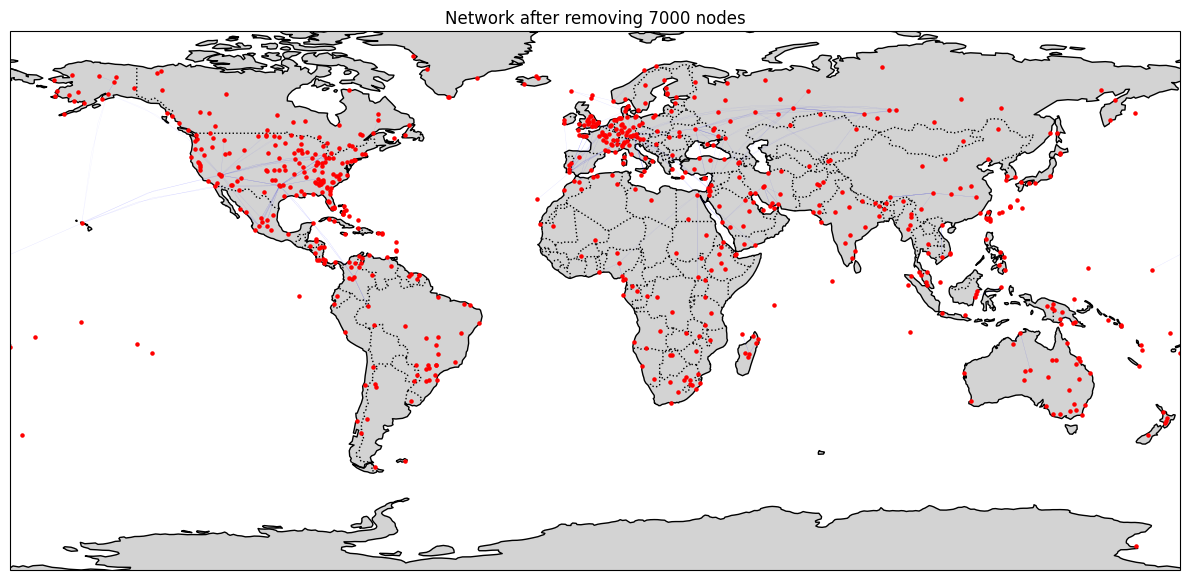

<ipython-input-8-5bb3f7d2bc1d>:58: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-8-5bb3f7d2bc1d>:107: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


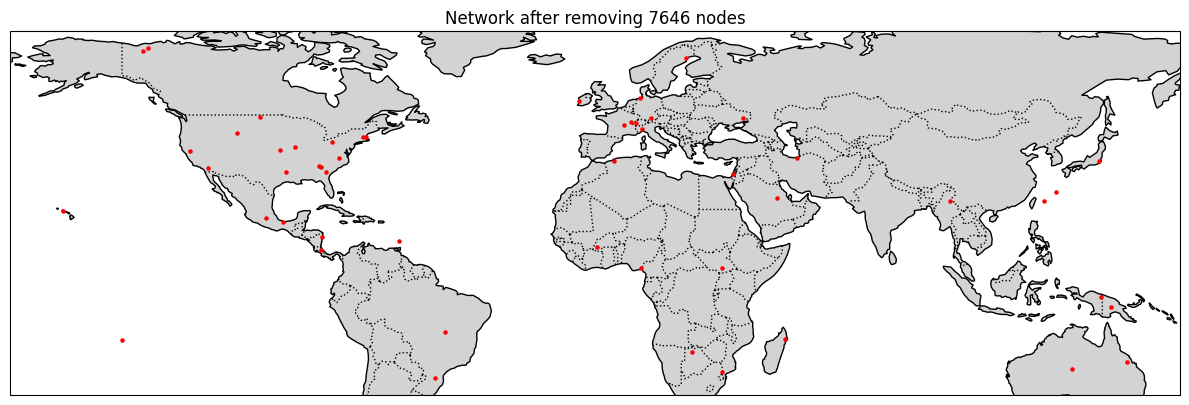


=== Random-Removal Simulation (protecting TLV & HNL) ===

Nodes removed: 1000
 Remaining nodes: 6698
 Largest component size: 2616
 Number of components: 4028
 Top 5 hubs:
   1. ATL (Atlanta, United States) – degree=1552
   2. ORD (Chicago, United States) – degree=911
   3. PEK (Beijing, China) – degree=895
   4. CDG (Paris, France) – degree=861
   5. FRA (Frankfurt, Germany) – degree=832
 Shortest TLV→HNL path:
   1. TLV (Tel-aviv, Israel)
   2. PEK (Beijing, China)
   3. HNL (Honolulu, United States)
  Total hops: 2
------------------------------------------------------------
Nodes removed: 2000
 Remaining nodes: 5698
 Largest component size: 2090
 Number of components: 3546
 Top 5 hubs:
   1. PEK (Beijing, China) – degree=759
   2. FRA (Frankfurt, Germany) – degree=720
   3. CDG (Paris, France) – degree=715
   4. LAX (Los Angeles, United States) – degree=690
   5. DFW (Dallas-Fort Worth, United States) – degree=668
 Shortest TLV→HNL path:
   1. TLV (Tel-aviv, Israel)
   2. PEK (Bei

In [8]:
import random


# ---------------------------------------------------------
# Assumptions:
# - 'G' is the original igraph.Graph with all airports already loaded.
# - Each vertex has:
#     • "name" = Airport ID string (e.g., "1590" for TLV)
#     • "iata" = IATA code (e.g., "TLV" or "HNL")
#     • "city", "country", "lat", "lon" attributes
# ---------------------------------------------------------

# Seed for reproducibility
random.seed(42)

# 1) Identify TLV and HNL by their IATA codes so we can protect them
tlv_vertex = G.vs.find(iata="TLV")
hnl_vertex = G.vs.find(iata="HNL")
tlv_id = tlv_vertex["name"]
hnl_id = hnl_vertex["name"]

# 2) Build removal_order excluding TLV and HNL
all_airport_ids = G.vs["name"][:]
removal_order = [aid for aid in all_airport_ids if aid not in {tlv_id, hnl_id}]
random.shuffle(removal_order)

# 3) Determine how many removable nodes: exclude TLV and HNL, then leave 50 unremoved
total_removal_candidates = len(removal_order)  # = G.vcount() - 2
max_removals = max(0, total_removal_candidates - 50)

# 4) Batch size and how many full batches + remainder
batch_size = 1000
num_batches = max_removals // batch_size
remainder = max_removals % batch_size

# 5) Copy the original graph for removal experiments
G_rem = G.copy()

# ---------------------------------------------------------
# Helper: find vertex index by airport-ID (name) if it still exists
# ---------------------------------------------------------
def get_vertex_index_by_id(graph, airport_id):
    try:
        return graph.vs.find(name=airport_id).index
    except ValueError:
        return None

# ---------------------------------------------------------
# Helper: compute shortest TLV→HNL path (fewest hops) if possible
# ---------------------------------------------------------
def compute_shortest_tlv_hnl(graph):
    tlv_vs = [v for v in graph.vs if v["iata"] == "TLV"]
    hnl_vs = [v for v in graph.vs if v["iata"] == "HNL"]
    if not tlv_vs or not hnl_vs:
        return None  # one or both missing
    tlv_idx = tlv_vs[0].index
    hnl_idx = hnl_vs[0].index
    paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
    if not paths or not paths[0]:
        return []  # no path exists
    return paths[0]

# ---------------------------------------------------------
# Function to remove a batch of IDs and record metrics
# ---------------------------------------------------------
def process_removal_batch(batch_ids, G_current, nodes_removed_count):
    # Delete these vertices
    to_delete = []
    for airport_id in batch_ids:
        vidx = get_vertex_index_by_id(G_current, airport_id)
        if vidx is not None:
            to_delete.append(vidx)
    G_current.delete_vertices(to_delete)

    # 1) Recompute degrees and find top 5 hubs
    degrees = G_current.degree(mode="all")
    G_current.vs["degree"] = degrees
    top5_vertices = sorted(G_current.vs, key=lambda v: v["degree"], reverse=True)[:5]
    top5_hubs = [
        {
            "rank": i + 1,
            "iata": v["iata"],
            "city": v["city"],
            "country": v["country"],
            "degree": v["degree"],
        }
        for i, v in enumerate(top5_vertices)
    ]

    # 2) Check TLV→HNL connectivity
    path_indices = compute_shortest_tlv_hnl(G_current)
    if path_indices is None:
        path_info = None
    elif not path_indices:
        path_info = []
    else:
        path_info = [
            {
                "iata": G_current.vs[idx]["iata"],
                "city": G_current.vs[idx]["city"],
                "country": G_current.vs[idx]["country"],
            }
            for idx in path_indices
        ]

    # 3) Largest weakly connected component size
    comp = G_current.clusters(mode="weak")
    largest_comp_size = max(comp.sizes()) if comp.sizes() else 0
    num_components = len(comp.sizes())

    return {
        "nodes_removed": nodes_removed_count,
        "remaining_nodes": G_current.vcount(),
        "largest_component_size": largest_comp_size,
        "num_components": num_components,
        "top5_hubs": top5_hubs,
        "tlv_hnl_path": path_info,
    }

# ---------------------------------------------------------
# Helper function to plot the current network on a world map
# ---------------------------------------------------------
def plot_network_on_world_map(graph, title, filename=None):
    """
    Plots all remaining airports and routes in `graph` on a PlateCarree world map.
    - graph: igraph Graph with vertex attributes "lat" and "lon".
    - title: string for the plot title.
    - filename: if provided, saves the figure to that filename; otherwise, shows it.
    """
    # Extract coordinates
    lats = graph.vs["lat"]
    lons = graph.vs["lon"]

    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale("110m"), facecolor="lightgray")
    ax.add_feature(cfeature.COASTLINE.with_scale("110m"))
    ax.add_feature(cfeature.BORDERS.with_scale("110m"), linestyle=":")

    # Plot each route as a faint line
    for edge in graph.es:
        tail_idx, head_idx = edge.tuple
        lat1, lon1 = graph.vs[tail_idx]["lat"], graph.vs[tail_idx]["lon"]
        lat2, lon2 = graph.vs[head_idx]["lat"], graph.vs[head_idx]["lon"]
        if lat1 is None or lon1 is None or lat2 is None or lon2 is None:
            continue
        ax.plot(
            [lon1, lon2],
            [lat1, lat2],
            transform=ccrs.Geodetic(),
            linewidth=0.3,
            color="blue",
            alpha=0.05,
        )

    # Plot airport nodes as small red dots
    ax.scatter(
        lons,
        lats,
        s=5,
        color="red",
        transform=ccrs.PlateCarree(),
        zorder=2
    )

    ax.set_title(title)
    plt.tight_layout()

  # -------------------- save / show / close -------------------
    if filename is not None:
        plt.savefig(filename, dpi=150)   # 1. write PNG
        plt.show()                       # 2. let Jupyter capture it
        plt.close()                      # 3. free memory
    else:
        plt.show()                       # show when no filename

# ---------------------------------------------------------
# 9) Iterate over batches, removing up to max_removals,
#    and at each step plot the current network state
# ---------------------------------------------------------
results = []
removed_ids = []
current_index = 0

# Remove in full batches of size 1000
for batch_idx in range(1, num_batches + 1):
    start = current_index
    end = current_index + batch_size
    batch_ids = removal_order[start:end]
    removed_ids.extend(batch_ids)
    current_index = end

    nodes_removed_count = len(removed_ids)
    res = process_removal_batch(batch_ids, G_rem, nodes_removed_count)
    results.append(res)

    # Plot the current network
    title = f"Network after removing {nodes_removed_count} nodes"
    filename = f"network_removed_{nodes_removed_count}.png"
    plot_network_on_world_map(G_rem, title, filename=filename)

# Handle the final smaller batch (if any)
if remainder > 0:
    batch_ids = removal_order[current_index : current_index + remainder]
    removed_ids.extend(batch_ids)
    nodes_removed_count = len(removed_ids)
    res = process_removal_batch(batch_ids, G_rem, nodes_removed_count)
    results.append(res)

    # Plot after final removal
    title = f"Network after removing {nodes_removed_count} nodes"
    filename = f"network_removed_{nodes_removed_count}.png"
    plot_network_on_world_map(G_rem, title, filename=filename)


# ---------------------------------------------------------
# 10) Print summary of results
# ---------------------------------------------------------
print("\n=== Random-Removal Simulation (protecting TLV & HNL) ===\n")
for res in results:
    print(f"Nodes removed: {res['nodes_removed']}")
    print(f" Remaining nodes: {res['remaining_nodes']}")
    print(f" Largest component size: {res['largest_component_size']}")
    print(f" Number of components: {res['num_components']}")
    print(" Top 5 hubs:")
    for hub in res["top5_hubs"]:
        print(f"   {hub['rank']}. {hub['iata']} ({hub['city']}, {hub['country']}) – degree={hub['degree']}")
    if res["tlv_hnl_path"] is None:
        print(" TLV or HNL is (unexpectedly) missing; no path check possible.")
    elif not res["tlv_hnl_path"]:
        print(" No TLV→HNL path exists.")
    else:
        print(" Shortest TLV→HNL path:")
        for hop_idx, hop in enumerate(res["tlv_hnl_path"], start=1):
            print(f"   {hop_idx}. {hop['iata']} ({hop['city']}, {hop['country']})")
        print(f"  Total hops: {len(res['tlv_hnl_path']) - 1}")
    print("-" * 60)



network disruption 10 runs

In [6]:
import numpy as np
from collections import defaultdict, Counter

# ---------------------------------------------------------
# Assumptions:
# - 'G' is the original igraph.Graph with all airports already loaded.
# - TLV & HNL IDs (tlv_id, hnl_id) and removal_order have been defined previously.
# ---------------------------------------------------------

runs = 10
batch_size = 1000
max_removals = max(0, len(removal_order) - 50)
num_batches = max_removals // batch_size
remainder = max_removals % batch_size
stop_points = [batch_size * i for i in range(1, num_batches + 1)]
if remainder:
    stop_points.append(batch_size * num_batches + remainder)

# Data structures to accumulate metrics
accum = {
    stop: {
        "remaining": [],
        "largest_comp": [],
        "hop_count": [],
        "hub_degs": defaultdict(list),    # rank -> list of degrees
        "hub_names": defaultdict(list),   # rank -> list of IATA codes
    }
    for stop in stop_points
}

def get_vertex_index_by_id(graph, airport_id):
    try:
        return graph.vs.find(name=airport_id).index
    except ValueError:
        return None

def compute_shortest_tlv_hnl(graph):
    tlv_vs = [v for v in graph.vs if v["iata"] == "TLV"]
    hnl_vs = [v for v in graph.vs if v["iata"] == "HNL"]
    if not tlv_vs or not hnl_vs:
        return None
    paths = graph.get_shortest_paths(
        tlv_vs[0].index,
        to=hnl_vs[0].index,
        mode="OUT",
        output="vpath"
    )
    return paths[0] if paths and paths[0] else []

for run in range(runs):
    order = removal_order.copy()
    random.shuffle(order)
    G_rem = G.copy()
    removed = []

    for stop in stop_points:
        # remove batch up to this stop
        batch = order[len(removed):stop]
        removed.extend(batch)
        idxs = [get_vertex_index_by_id(G_rem, aid) for aid in batch]
        G_rem.delete_vertices([i for i in idxs if i is not None])

        # record remaining node count
        accum[stop]["remaining"].append(G_rem.vcount())

        # record largest weak component size
        comp = G_rem.clusters(mode="weak")
        accum[stop]["largest_comp"].append(
            max(comp.sizes()) if comp.sizes() else 0
        )

        # record TLV->HNL hop count
        path = compute_shortest_tlv_hnl(G_rem)
        hops = (len(path) - 1) if path else np.nan
        accum[stop]["hop_count"].append(hops)

        # record top-5 hubs
        degs = G_rem.degree(mode="all")
        vs_degs = sorted(zip(G_rem.vs, degs), key=lambda x: -x[1])[:5]
        for rank, (v, d) in enumerate(vs_degs, start=1):
            accum[stop]["hub_degs"][rank].append(d)
            accum[stop]["hub_names"][rank].append(v["iata"])

# Compute and present averaged results
print(f"\n=== Averaged Results over {runs} runs ===\n")
for stop in stop_points:
    m = accum[stop]
    avg_rem   = np.mean(m["remaining"])
    avg_comp  = np.mean(m["largest_comp"])
    avg_hops  = np.nanmean(m["hop_count"])
    print(f"After ~{stop} removals:")
    print(f"  Avg remaining nodes   : {avg_rem:.1f}")
    print(f"  Avg largest component : {avg_comp:.1f}")
    print(f"  Avg TLV→HNL hops      : {avg_hops:.2f}")
    print("  Top 5 hubs (avg degree):")
    for rank in range(1, 6):
        avg_deg = np.mean(m["hub_degs"][rank])
        common  = Counter(m["hub_names"][rank]).most_common(1)[0][0]
        print(f"    {rank}. {common} (deg≈{avg_deg:.1f})")
    print()


<ipython-input-6-fe291e78c495>:67: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_rem.clusters(mode="weak")
<ipython-input-6-fe291e78c495>:42: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(



=== Averaged Results over 10 runs ===

After ~1000 removals:
  Avg remaining nodes   : 6698.0
  Avg largest component : 2608.6
  Avg TLV→HNL hops      : 2.00
  Top 5 hubs (avg degree):
    1. ATL (deg≈1517.5)
    2. ORD (deg≈950.2)
    3. LHR (deg≈914.0)
    4. CDG (deg≈887.9)
    5. LAX (deg≈851.5)

After ~2000 removals:
  Avg remaining nodes   : 5698.0
  Avg largest component : 2074.3
  Avg TLV→HNL hops      : 2.00
  Top 5 hubs (avg degree):
    1. ATL (deg≈1176.6)
    2. ORD (deg≈789.7)
    3. CDG (deg≈757.6)
    4. FRA (deg≈728.4)
    5. JFK (deg≈674.7)

After ~3000 removals:
  Avg remaining nodes   : 4698.0
  Avg largest component : 1578.2
  Avg TLV→HNL hops      : 2.00
  Top 5 hubs (avg degree):
    1. ATL (deg≈968.7)
    2. ORD (deg≈639.1)
    3. LHR (deg≈615.2)
    4. CDG (deg≈580.5)
    5. JFK (deg≈547.6)

After ~4000 removals:
  Avg remaining nodes   : 3698.0
  Avg largest component : 1118.3
  Avg TLV→HNL hops      : 2.10
  Top 5 hubs (avg degree):
    1. ATL (deg≈705.6)
   

<ipython-input-6-fe291e78c495>:90: RuntimeWarning: Mean of empty slice
  avg_hops  = np.nanmean(m["hop_count"])


number of nodes in largest component while nodes are removed

<ipython-input-13-2752d2d4e3a7>:11: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")


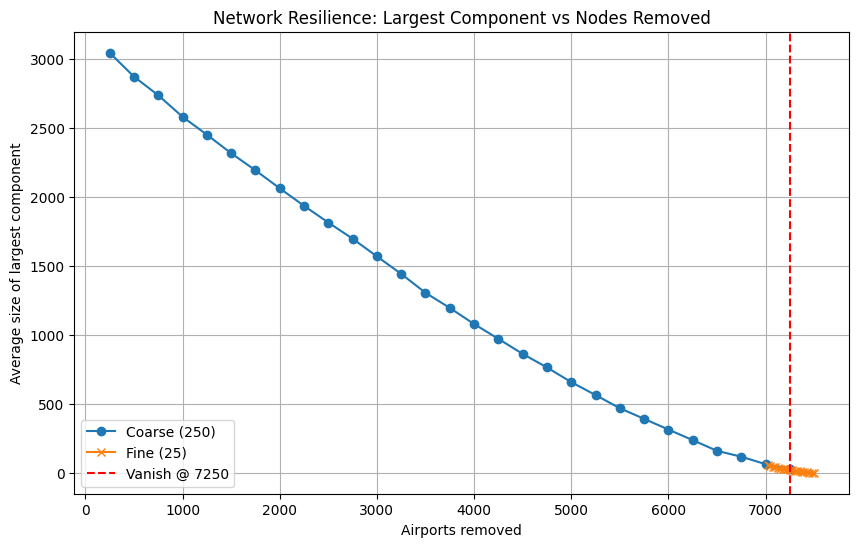

In [13]:

# ---------------------------------------------------------
# 2) Helpers and preparation
# ---------------------------------------------------------
def largest_comp_or_zero(graph):
    # check TLV→HNL path
    try:
        tlv_idx = graph.vs.find(iata="TLV").index
        hnl_idx = graph.vs.find(iata="HNL").index
    except ValueError:
        return 0
    paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
    path = paths[0] if paths and paths[0] else None
    if not path:
        return 0
    comps = graph.connected_components(mode="weak")
    return max(comps.sizes()) if comps.sizes() else 0

# Build removal list, protect TLV/HNL
tlv_id = G.vs.find(iata="TLV")["name"]
hnl_id = G.vs.find(iata="HNL")["name"]
removal_ids = [v["name"] for v in G.vs if v["name"] not in {tlv_id, hnl_id}]

# ---------------------------------------------------------
# 3) Simulation parameters
# ---------------------------------------------------------
runs         = 10
max_removals = len(removal_ids)
coarse_step  = 250
fine_step    = 25

# ---------------------------------------------------------
# 4) Determine vanish point from a reference run
# ---------------------------------------------------------
order = removal_ids.copy()
random.shuffle(order)
G_ref = G.copy()
removed = []
vanish_point = None

for stop in range(coarse_step, max_removals+1, coarse_step):
    to_remove = order[len(removed):stop]
    removed.extend(to_remove)
    delete_idxs = []
    for aid in to_remove:
        try:
            delete_idxs.append(G_ref.vs.find(name=aid).index)
        except ValueError:
            pass
    G_ref.delete_vertices(delete_idxs)
    if largest_comp_or_zero(G_ref) == 0:
        vanish_point = stop
        break

# Build stop lists
coarse_stops = list(range(coarse_step, vanish_point+1, coarse_step))
start = max(0, vanish_point - coarse_step)
end   = min(max_removals, vanish_point + coarse_step)
fine_stops   = list(range(start+fine_step, end+1, fine_step))

# Initialize accumulators
coarse_data = {s: [] for s in coarse_stops}
fine_data   = {s: [] for s in fine_stops}

# ---------------------------------------------------------
# 5) Run all simulations
# ---------------------------------------------------------
for run in range(runs):
    order = removal_ids.copy()
    random.shuffle(order)
    G_rem = G.copy()
    removed = []

    # Coarse sampling
    for stop in coarse_stops:
        to_remove = order[len(removed):stop]
        removed.extend(to_remove)
        delete_idxs = []
        for aid in to_remove:
            try:
                delete_idxs.append(G_rem.vs.find(name=aid).index)
            except ValueError:
                pass
        G_rem.delete_vertices(delete_idxs)
        coarse_data[stop].append(largest_comp_or_zero(G_rem))
        if coarse_data[stop][-1] == 0:
            break

    # Fine sampling
    G_rem = G.copy()
    removed = []
    for stop in fine_stops:
        to_remove = order[len(removed):stop]
        removed.extend(to_remove)
        delete_idxs = []
        for aid in to_remove:
            try:
                delete_idxs.append(G_rem.vs.find(name=aid).index)
            except ValueError:
                pass
        G_rem.delete_vertices(delete_idxs)
        fine_data[stop].append(largest_comp_or_zero(G_rem))

# ---------------------------------------------------------
# 6) Compute averages and plot
# ---------------------------------------------------------
avg_coarse = {s: np.mean(coarse_data[s]) for s in coarse_stops}
avg_fine   = {s: np.mean(fine_data[s])   for s in fine_stops}

plt.figure(figsize=(10,6))
plt.plot(list(avg_coarse.keys()), list(avg_coarse.values()), '-o', label='Coarse (250)')
plt.plot(list(avg_fine.keys()),   list(avg_fine.values()),   '-x', label='Fine (25)')
plt.axvline(vanish_point, color='red', linestyle='--', label=f'Vanish @ {vanish_point}')
plt.xlabel('Airports removed')
plt.ylabel('Average size of largest component')
plt.title('Network Resilience: Largest Component vs Nodes Removed')
plt.legend()
plt.grid(True)
plt.show()

network disruption - targeted removal

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


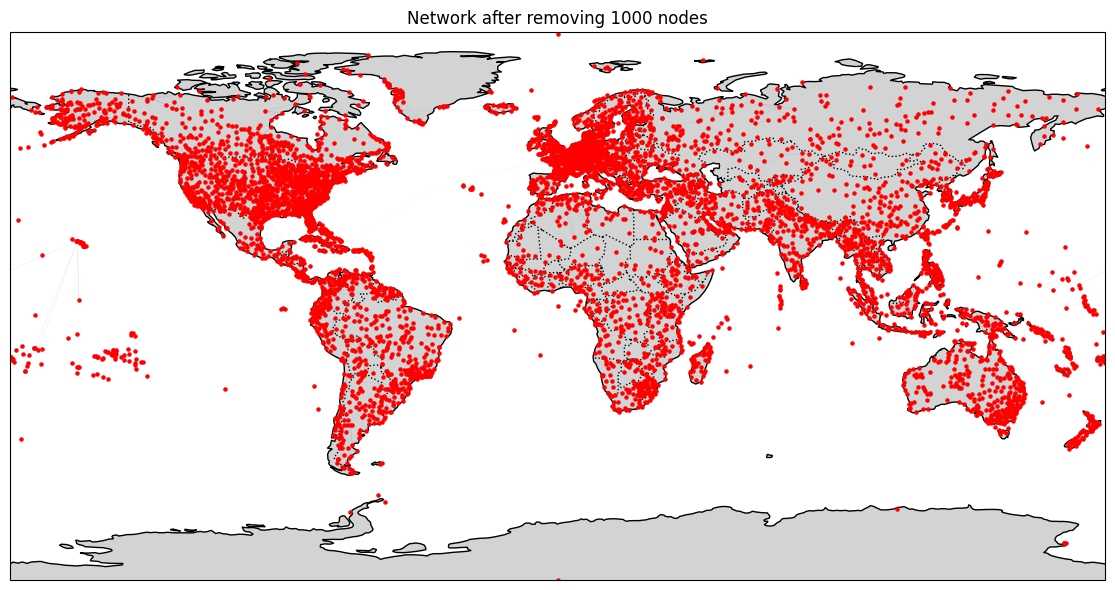

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


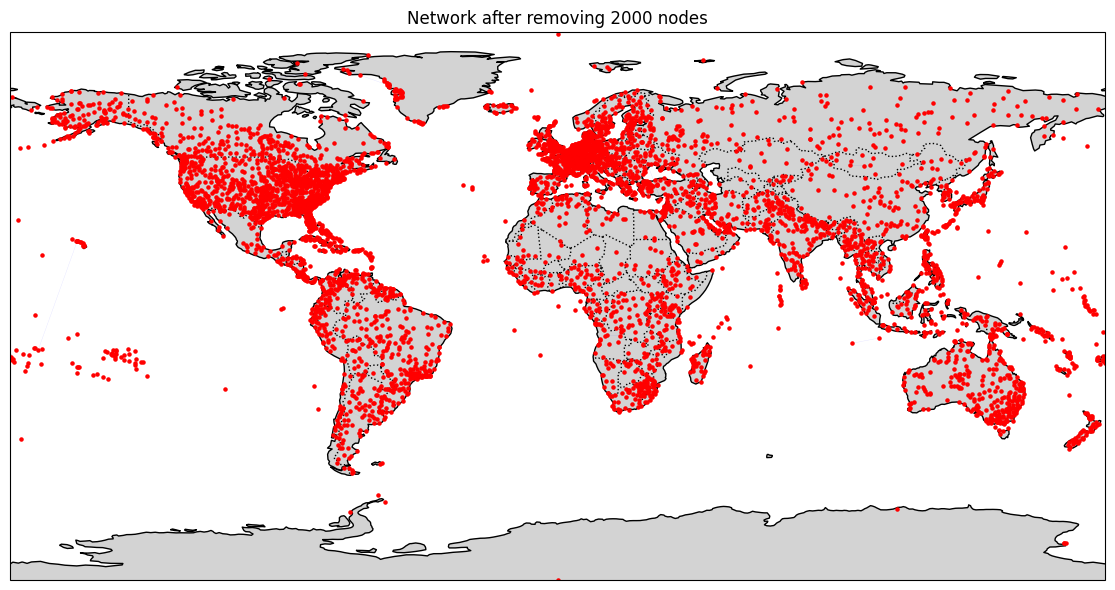

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


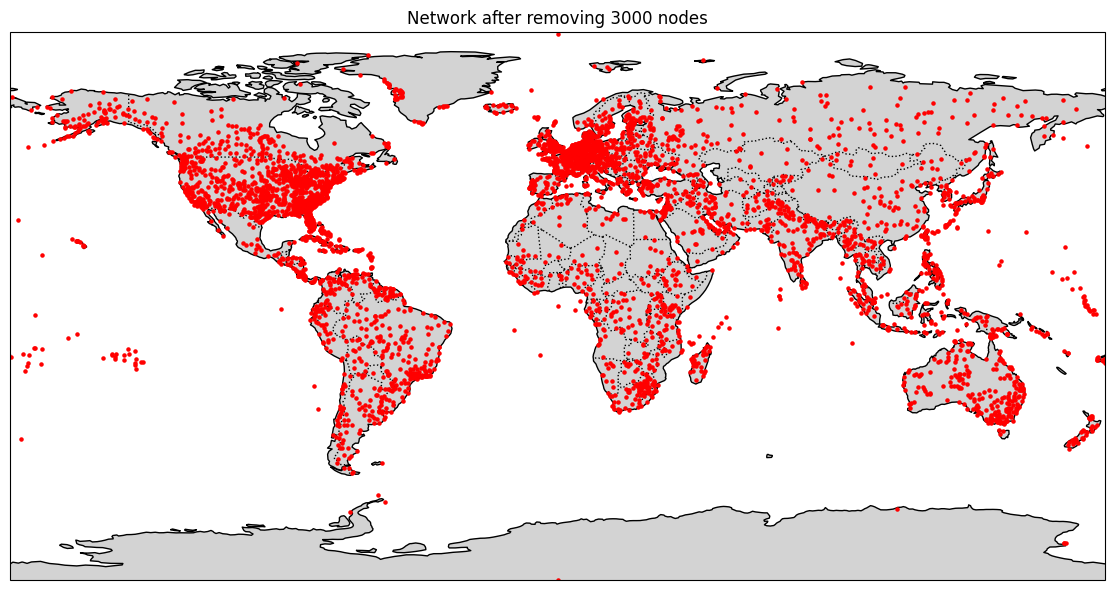

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


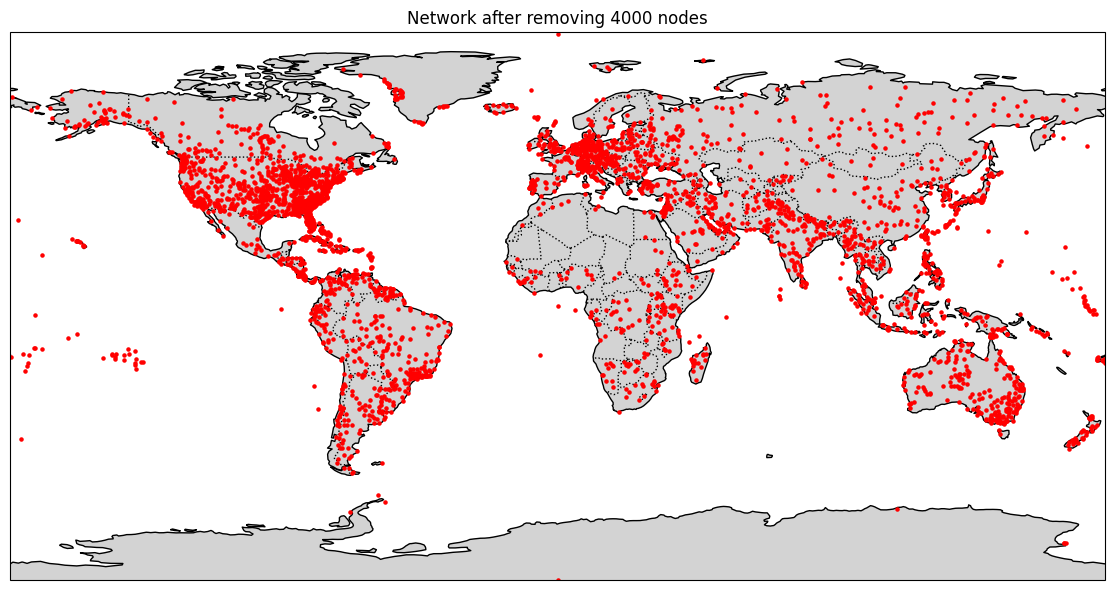

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


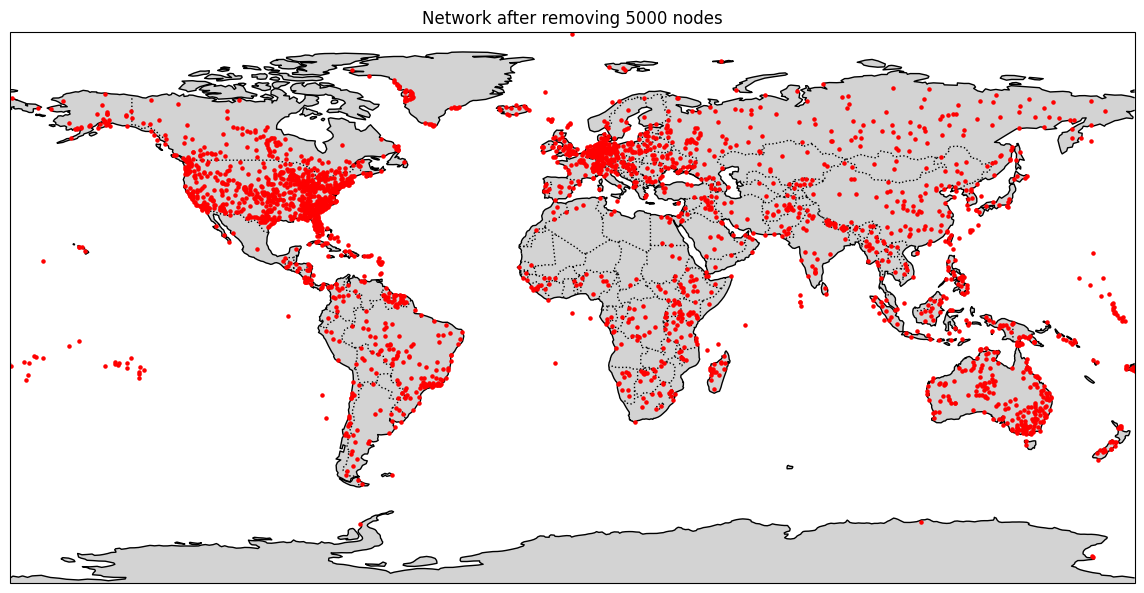

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


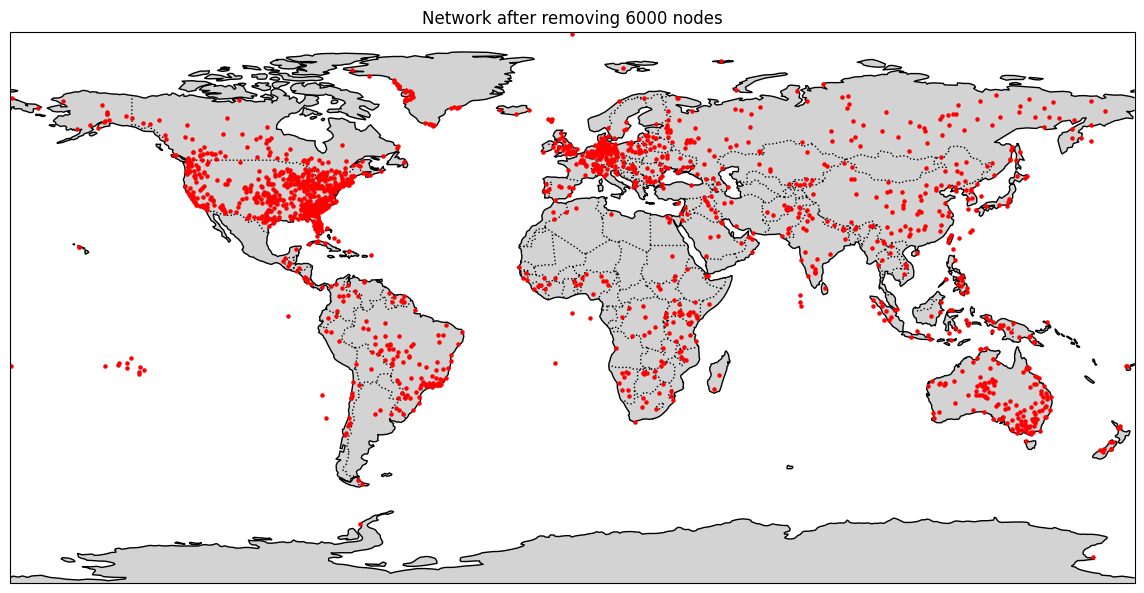

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


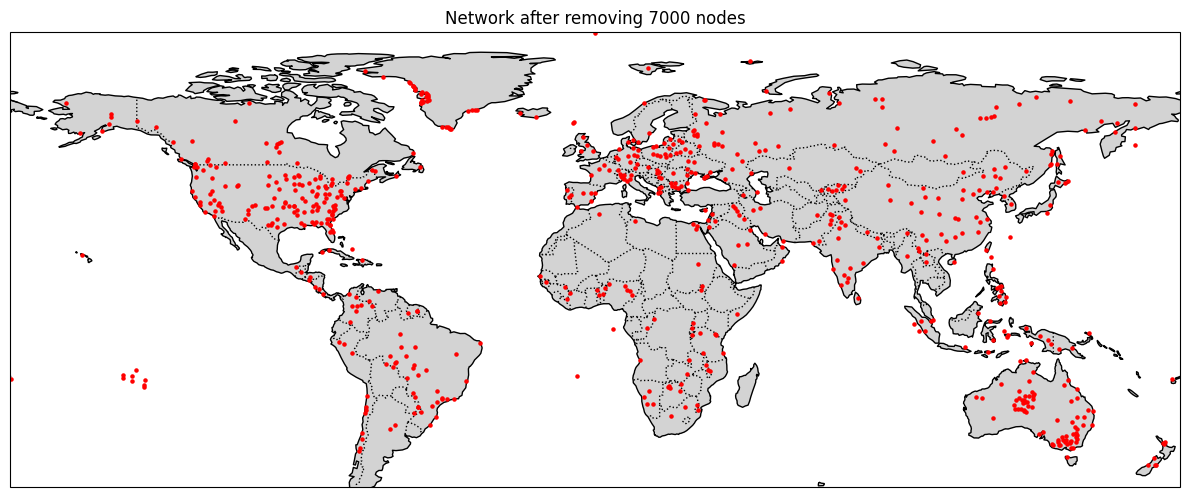

<ipython-input-14-6932f4d45750>:76: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
<ipython-input-14-6932f4d45750>:125: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  comp = G_current.clusters(mode="weak")


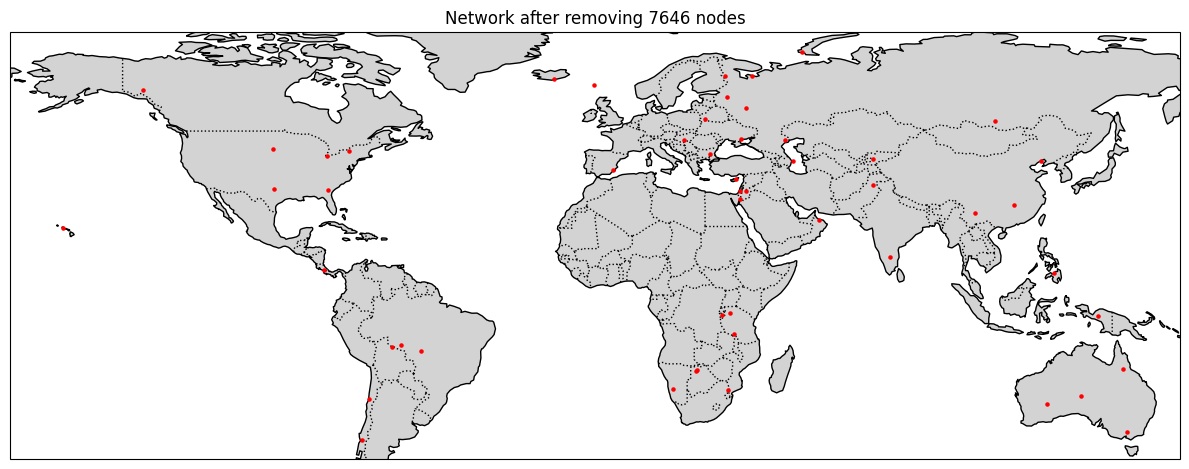


=== Targeted-Removal Simulation (protecting TLV & HNL) ===

Nodes removed: 1000
 Remaining nodes: 6698
 Largest component size: 34
 Number of components: 6025
 Top 5 hubs:
   1. HNL (Honolulu, United States) – degree=24
   2. GEA (Noumea, New Caledonia) – degree=17
   3. YEV (Inuvik, Canada) – degree=16
   4. GOH (Godthaab, Greenland) – degree=14
   5. TDD (Trinidad, Bolivia) – degree=14
 No TLV→HNL path exists.
------------------------------------------------------------
Nodes removed: 2000
 Remaining nodes: 5698
 Largest component size: 5
 Number of components: 5550
 Top 5 hubs:
   1. YRB (Resolute, Canada) – degree=4
   2. MGZ (Myeik, Burma) – degree=4
   3. BFI (Seattle, United States) – degree=4
   4. HNL (Honolulu, United States) – degree=4
   5. NAQ (Qaanaaq, Greenland) – degree=4
 No TLV→HNL path exists.
------------------------------------------------------------
Nodes removed: 3000
 Remaining nodes: 4698
 Largest component size: 4
 Number of components: 4688
 Top 5 hubs:
   

In [14]:
import random


# ---------------------------------------------------------
# Assumptions:
# - 'G' is the original igraph.Graph with all airports already loaded.
# - Each vertex has:
#     • "name" = Airport ID string (e.g., "1590" for TLV)
#     • "iata" = IATA code (e.g., "TLV" or "HNL")
#     • "city", "country", "lat", "lon" attributes
# ---------------------------------------------------------



# ---------------------------------------------------------
# 1) Build removal_order excluding TLV & HNL, sorted by descending degree
# ---------------------------------------------------------
tlv_id = G.vs.find(iata="TLV")["name"]
hnl_id = G.vs.find(iata="HNL")["name"]

# Exclude TLV & HNL
candidate_vs = [v for v in G.vs if v["name"] not in {tlv_id, hnl_id}]

# Sort vertices by descending total degree
degrees = G.degree(mode="all")
# Build list of (vertex, degree), filter out TLV/HNL
vd_pairs = [(v["name"], degrees[v.index]) for v in candidate_vs]
# Sort by degree descending
vd_pairs.sort(key=lambda x: x[1], reverse=True)

# removal_order is now the airport IDs from highest-degree to lowest
removal_order = [airport_id for airport_id, deg in vd_pairs]

# ---------------------------------------------------------
# 2) The rest of your code stays the same, except remove any random.shuffle calls:
#    (You no longer call random.shuffle(removal_order).)
# ---------------------------------------------------------


# 3) Determine how many removable nodes: exclude TLV and HNL, then leave 50 unremoved
total_removal_candidates = len(removal_order)  # = G.vcount() - 2
max_removals = max(0, total_removal_candidates - 50)

# 4) Batch size and how many full batches + remainder
batch_size = 1000
num_batches = max_removals // batch_size
remainder = max_removals % batch_size

# 5) Copy the original graph for removal experiments
G_rem = G.copy()



# ---------------------------------------------------------
# Helper: find vertex index by airport-ID (name) if it still exists
# ---------------------------------------------------------
def get_vertex_index_by_id(graph, airport_id):
    try:
        return graph.vs.find(name=airport_id).index
    except ValueError:
        return None

# ---------------------------------------------------------
# Helper: compute shortest TLV→HNL path (fewest hops) if possible
# ---------------------------------------------------------
def compute_shortest_tlv_hnl(graph):
    tlv_vs = [v for v in graph.vs if v["iata"] == "TLV"]
    hnl_vs = [v for v in graph.vs if v["iata"] == "HNL"]
    if not tlv_vs or not hnl_vs:
        return None  # one or both missing
    tlv_idx = tlv_vs[0].index
    hnl_idx = hnl_vs[0].index
    paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")
    if not paths or not paths[0]:
        return []  # no path exists
    return paths[0]

# ---------------------------------------------------------
# Function to remove a batch of IDs and record metrics
# ---------------------------------------------------------
def process_removal_batch(batch_ids, G_current, nodes_removed_count):
    # Delete these vertices
    to_delete = []
    for airport_id in batch_ids:
        vidx = get_vertex_index_by_id(G_current, airport_id)
        if vidx is not None:
            to_delete.append(vidx)
    G_current.delete_vertices(to_delete)

    # 1) Recompute degrees and find top 5 hubs
    degrees = G_current.degree(mode="all")
    G_current.vs["degree"] = degrees
    top5_vertices = sorted(G_current.vs, key=lambda v: v["degree"], reverse=True)[:5]
    top5_hubs = [
        {
            "rank": i + 1,
            "iata": v["iata"],
            "city": v["city"],
            "country": v["country"],
            "degree": v["degree"],
        }
        for i, v in enumerate(top5_vertices)
    ]

    # 2) Check TLV→HNL connectivity
    path_indices = compute_shortest_tlv_hnl(G_current)
    if path_indices is None:
        path_info = None
    elif not path_indices:
        path_info = []
    else:
        path_info = [
            {
                "iata": G_current.vs[idx]["iata"],
                "city": G_current.vs[idx]["city"],
                "country": G_current.vs[idx]["country"],
            }
            for idx in path_indices
        ]

    # 3) Largest weakly connected component size
    comp = G_current.clusters(mode="weak")
    largest_comp_size = max(comp.sizes()) if comp.sizes() else 0
    num_components = len(comp.sizes())

    return {
        "nodes_removed": nodes_removed_count,
        "remaining_nodes": G_current.vcount(),
        "largest_component_size": largest_comp_size,
        "num_components": num_components,
        "top5_hubs": top5_hubs,
        "tlv_hnl_path": path_info,
    }

# ---------------------------------------------------------
# Helper function to plot the current network on a world map
# ---------------------------------------------------------
def plot_network_on_world_map(graph, title, filename=None):
    """
    Plots all remaining airports and routes in `graph` on a PlateCarree world map.
    - graph: igraph Graph with vertex attributes "lat" and "lon".
    - title: string for the plot title.
    - filename: if provided, saves the figure to that filename; otherwise, shows it.
    """
    # Extract coordinates
    lats = graph.vs["lat"]
    lons = graph.vs["lon"]

    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale("110m"), facecolor="lightgray")
    ax.add_feature(cfeature.COASTLINE.with_scale("110m"))
    ax.add_feature(cfeature.BORDERS.with_scale("110m"), linestyle=":")

    # Plot each route as a faint line
    for edge in graph.es:
        tail_idx, head_idx = edge.tuple
        lat1, lon1 = graph.vs[tail_idx]["lat"], graph.vs[tail_idx]["lon"]
        lat2, lon2 = graph.vs[head_idx]["lat"], graph.vs[head_idx]["lon"]
        if lat1 is None or lon1 is None or lat2 is None or lon2 is None:
            continue
        ax.plot(
            [lon1, lon2],
            [lat1, lat2],
            transform=ccrs.Geodetic(),
            linewidth=0.3,
            color="blue",
            alpha=0.05,
        )

    # Plot airport nodes as small red dots
    ax.scatter(
        lons,
        lats,
        s=5,
        color="red",
        transform=ccrs.PlateCarree(),
        zorder=2
    )

    ax.set_title(title)
    plt.tight_layout()

  # -------------------- save / show / close -------------------
    if filename is not None:
        plt.savefig(filename, dpi=150)   # 1. write PNG
        plt.show()                       # 2. let Jupyter capture it
        plt.close()                      # 3. free memory
    else:
        plt.show()                       # show when no filename

# ---------------------------------------------------------
# 9) Iterate over batches, removing up to max_removals,
#    and at each step plot the current network state
# ---------------------------------------------------------
results = []
removed_ids = []
current_index = 0

# Remove in full batches of size 1000
for batch_idx in range(1, num_batches + 1):
    start = current_index
    end = current_index + batch_size
    batch_ids = removal_order[start:end]
    removed_ids.extend(batch_ids)
    current_index = end

    nodes_removed_count = len(removed_ids)
    res = process_removal_batch(batch_ids, G_rem, nodes_removed_count)
    results.append(res)

    # Plot the current network
    title = f"Network after removing {nodes_removed_count} nodes"
    filename = f"network_removed_{nodes_removed_count}.png"
    plot_network_on_world_map(G_rem, title, filename=filename)

# Handle the final smaller batch (if any)
if remainder > 0:
    batch_ids = removal_order[current_index : current_index + remainder]
    removed_ids.extend(batch_ids)
    nodes_removed_count = len(removed_ids)
    res = process_removal_batch(batch_ids, G_rem, nodes_removed_count)
    results.append(res)

    # Plot after final removal
    title = f"Network after removing {nodes_removed_count} nodes"
    filename = f"network_removed_{nodes_removed_count}.png"
    plot_network_on_world_map(G_rem, title, filename=filename)


# ---------------------------------------------------------
# 10) Print summary of results
# ---------------------------------------------------------
print("\n=== Targeted-Removal Simulation (protecting TLV & HNL) ===\n")
for res in results:
    print(f"Nodes removed: {res['nodes_removed']}")
    print(f" Remaining nodes: {res['remaining_nodes']}")
    print(f" Largest component size: {res['largest_component_size']}")
    print(f" Number of components: {res['num_components']}")
    print(" Top 5 hubs:")
    for hub in res["top5_hubs"]:
        print(f"   {hub['rank']}. {hub['iata']} ({hub['city']}, {hub['country']}) – degree={hub['degree']}")
    if res["tlv_hnl_path"] is None:
        print(" TLV or HNL is (unexpectedly) missing; no path check possible.")
    elif not res["tlv_hnl_path"]:
        print(" No TLV→HNL path exists.")
    else:
        print(" Shortest TLV→HNL path:")
        for hop_idx, hop in enumerate(res["tlv_hnl_path"], start=1):
            print(f"   {hop_idx}. {hop['iata']} ({hop['city']}, {hop['country']})")
        print(f"  Total hops: {len(res['tlv_hnl_path']) - 1}")
    print("-" * 60)


number of nodes in largest component while nodes are removed - targeted removal

<ipython-input-21-d88e09787ed8>:23: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:444
  paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")[0]


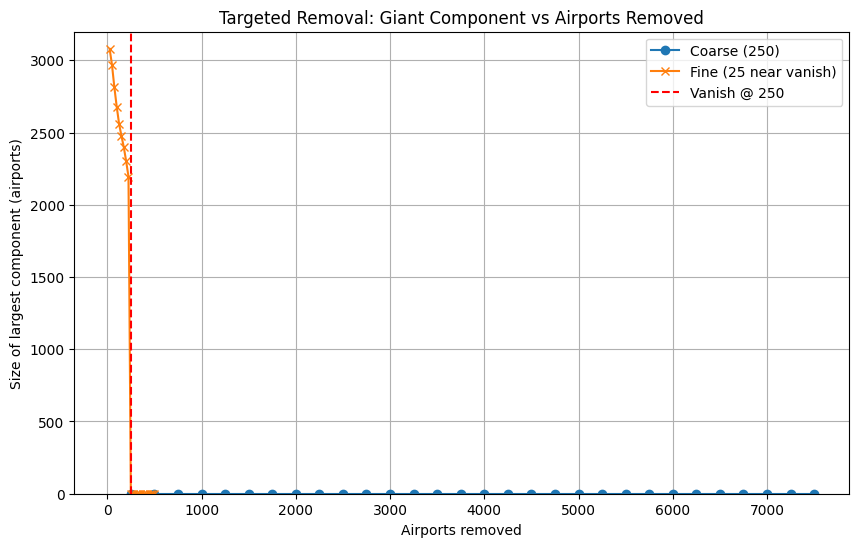

In [21]:
# --- 1) Build G as before ... (load airports/routes, construct G) ---

# --- 2) Identify TLV/HNL and build targeted removal order ---
tlv_idx = G.vs.find(iata="TLV").index
hnl_idx = G.vs.find(iata="HNL").index

# Exclude TLV & HNL, sort remaining by descending degree
degrees = G.degree(mode="all")
pairs = [(v["name"], degrees[v.index]) for v in G.vs if v.index not in (tlv_idx, hnl_idx)]
pairs.sort(key=lambda x: x[1], reverse=True)
removal_ids = [aid for aid,_ in pairs]

# --- 3) Simulation parameters ---
max_removals = len(removal_ids)
coarse_step  = 250
fine_step    = 25

# Stops
coarse_stops = list(range(coarse_step, max_removals+1, coarse_step))

# Helper to check reachability
def has_path(graph):
    paths = graph.get_shortest_paths(tlv_idx, to=hnl_idx, mode="OUT", output="vpath")[0]
    return bool(paths)

# --- 4) Find vanish point (coarse) ---
G_ref = G.copy()
removed = []
vanish_pt = None

for stop in coarse_stops:
    batch = removal_ids[len(removed):stop]
    removed.extend(batch)
    # delete
    idxs = [G_ref.vs.find(name=aid).index for aid in batch]
    G_ref.delete_vertices(idxs)
    if not has_path(G_ref):
        vanish_pt = stop
        break

# Build fine stops around vanish
start = max(0, vanish_pt - coarse_step)
end   = min(max_removals, vanish_pt + coarse_step)
fine_stops = list(range(start + fine_step, end+1, fine_step))

# --- 5) Collect giant‐component sizes ---
coarse_sizes = []
G_run = G.copy()
removed = []
for stop in coarse_stops:
    batch = removal_ids[len(removed):stop]
    removed.extend(batch)
    idxs = [G_run.vs.find(name=aid).index for aid in batch]
    G_run.delete_vertices(idxs)
    comp = G_run.connected_components(mode="weak")
    size = max(comp.sizes()) if comp.sizes() else 0
    # optionally zero out after vanish:
    if stop >= vanish_pt:
        size = 0
    coarse_sizes.append(size)

fine_sizes = []
G_run = G.copy()
removed = []
for stop in fine_stops:
    batch = removal_ids[len(removed):stop]
    removed.extend(batch)
    idxs = [G_run.vs.find(name=aid).index for aid in batch]
    G_run.delete_vertices(idxs)
    comp = G_run.connected_components(mode="weak")
    size = max(comp.sizes()) if comp.sizes() else 0
    if stop >= vanish_pt:
        size = 0
    fine_sizes.append(size)

# --- 6) Plot absolute sizes ---
initial_size = max(G.connected_components(mode="weak").sizes())
plt.figure(figsize=(10,6))
plt.plot(coarse_stops, coarse_sizes, '-o', label='Coarse (250)')
plt.plot(fine_stops,   fine_sizes,   '-x', label='Fine (25 near vanish)')
plt.axvline(vanish_pt, color='red', linestyle='--', label=f'Vanish @ {vanish_pt}')
plt.ylim(0, initial_size + 10)
plt.xlabel('Airports removed')
plt.ylabel('Size of largest component (airports)')
plt.title('Targeted Removal: Giant Component vs Airports Removed')
plt.legend()
plt.grid(True)
plt.show()

